# **Model based on VGG-16 - Autonomous Vehicle Grand Theft Auto V**

This notebook was developed to build, train and validate the model used to control autonomous vehicle in GTA V game. This project is the result of an undergraduate thesis written by Gustavo Antonio Magera Novello and Henrique Yda Yamamoto with the supervision of Prof. Eduardo Lobo Lustosa Cabral in Mechatronics Engineering Department of Polytechnic School of the University of São Paulo. This model was trained using Google Colaboratory sessions due its free 12GB GPU availability.

## **Importing general libraries**
Importing general purpose libraries

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import keras
import shutil
import os
import random

Using TensorFlow backend.


## **Getting data**

It is necessary to get training data processed by "VGG_preprocessor" notebook, which runs the entire VGG16 convolutional base over the dataset available in https://github.com/elcabral/Autonomous-vehicle-dataset and records its output in a Google Drive folder to be used by densely connected layers. This reduces a lot training time because it runs convolutional base only once for every image, which is the most expensive part. This process is well decribed in page 146 of Deep Learning with Python book by François Chollet. 

The code below mounts Google Drive folder in Google Colab disk to get data from it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Path to folder in Google Drive to features, labels and normalized speed

In [ ]:
x = np.load('/content/drive/My Drive/Novos_Dados/vgg_pred_avg/vgg_pred_avg.npy')
y = np.load('/content/drive/My Drive/Novos_Dados/vgg_pred_avg/y_vgg_pred_avg.npy')
vn = np.load('/content/drive/My Drive/Novos_Dados/vgg_pred_avg/vn_vgg_pred_avg.npy')

## **Splitting and shuffling data**

Data is split in train and test and shuffled to increase variability.

In [ ]:
np.random.seed(seed=9)
np.random.shuffle(x)
np.random.seed(seed=9)
np.random.shuffle(y)
np.random.seed(seed=9)
np.random.shuffle(vn)

In [ ]:
xtreino = x[0:len(x)-25000]
ytreino = y[0:len(y)-25000]
vntreino = vn[0:len(vn)-25000]
xteste = x[len(x)-25000:len(x)]
yteste = y[len(y)-25000:len(y)]
vnteste = vn[len(vn)-25000:len(vn)]

## **Creating model**

The model is built using Keras library.

Importing Keras modules

In [ ]:
from keras import models, Input
from keras.layers import Input, Flatten, Dense, InputLayer, Dropout, Lambda, Conv2D, LSTM
from keras.models import load_model, Model
from keras.layers import concatenate
from keras.applications.vgg16 import VGG16

This is the visual part (with convolutional layers) of model which process image data. It has an input layer of shape (14336,) that is compatible to output shape of flatten layer of pretrained VGG16 model, then densely connected and dropout layers are added.

In [ ]:
#Visual model
input_visual = Input(shape=(14336,), name='input_visual')
visual_fc_1 = Dense(256, activation='relu')(input_visual)
visual_dropout_1 = Dropout(0.4)(visual_fc_1)
visual_fc_2 = Dense(50, activation='relu')(visual_dropout_1)
visual_dropout_2 = Dropout(0.3)(visual_fc_2)

This part of model process sequential speed data. It has an input layer of shape (1,50) followed by recurrent layers with long short term memory (LSTM) units, dropout and densely connected layers.

In [ ]:
#Speed model
input_speed = Input(shape=(1,50), name='input_speed')
speed_lstm = LSTM(128)(input_speed)
speed_fc_1 = Dense(50, activation='relu')(speed_lstm)
speed_dropout_1 = Dropout(0.3)(speed_fc_1)
concatenated = concatenate([visual_fc_2, speed_fc_1], axis=-1)
speed_fc_2 = Dense(50, activation='relu')(concatenated)
output = Dense(3, activation='sigmoid')(speed_fc_2)

model = Model([input_visual, input_speed], output)

## **Model visualization**

A summary of the model is given below:

In [ ]:
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_visual (InputLayer)       (None, 14336)        0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          3670272     input_visual[0][0]               
__________________________________________________________________________________________________
input_speed (InputLayer)        (None, 1, 50)        0                                            
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 256)          0           dense_11[0][0]                   
____________________________________________________________________________________________

And a diagram of the model with all shapes:

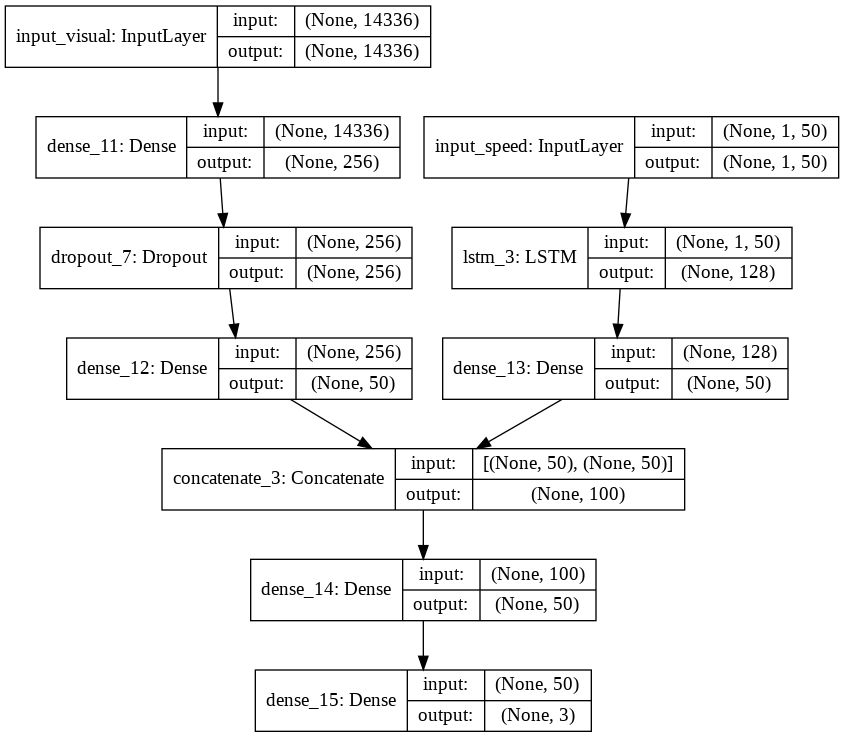

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file = 'model.png', show_shapes = True)

## **Setting optimizer  and callbacks**



Three callbacks are set:


* Model checkpoint: This saves the model in .hdf5 file for each epoch, so it is possible to restore training progress in any epoch;
* CSV logger: Saves training loss and metrics values for each epoch in .csv file;
* ReduceLRonPlateau: Reduces learning rate by a factor of 0.2 when val_loss doesn't decrease for 5 epochs.




In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/Treinamentos/Xception_MultiModal_Predict_Speed/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5',
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        mode='min',
    ),
    keras.callbacks.CSVLogger(
        filename= '/content/drive/My Drive/Treinamentos/VGG_MultiModal_Predict_Speed/log.csv', 
        separator=',',
        append=True,
    )
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
  ]

The loss function is mean squared error and metrics is mean average error

In [ ]:
from keras.optimizers import Adam, SGD, RMSprop
adam = Adam(lr=1e-4)
model.compile(optimizer=adam,
              loss='mse',
              metrics=['mae'])

## **Training model**

We separate 20% of training dataset to validate model. Note that because of data preprocessing in "" notebook, time per epoch is very low.

In [ ]:
history = model.fit(x=[xtreino,vntreino],
                    y=ytreino[:,0:3],
                    epochs=100,
                    verbose=1,
                    validation_split=0.20,
                    batch_size=128,
                    callbacks=callbacks_list,
                    use_multiprocessing=True,
                    workers=6)

Train on 78386 samples, validate on 26129 samples
Epoch 1/200
78386/78386 [==============================] - 9s 116us/step - loss: 0.0120 - mae: 0.0787 - val_loss: 0.0050 - val_mae: 0.0459
Epoch 2/200
78386/78386 [==============================] - 7s 87us/step - loss: 0.0063 - mae: 0.0543 - val_loss: 0.0041 - val_mae: 0.0396
Epoch 3/200
78386/78386 [==============================] - 7s 87us/step - loss: 0.0050 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0352
Epoch 4/200
78386/78386 [==============================] - 7s 86us/step - loss: 0.0043 - mae: 0.0430 - val_loss: 0.0034 - val_mae: 0.0352
Epoch 5/200
78386/78386 [==============================] - 7s 86us/step - loss: 0.0040 - mae: 0.0405 - val_loss: 0.0031 - val_mae: 0.0336
Epoch 6/200
78386/78386 [==============================] - 7s 86us/step - loss: 0.0037 - mae: 0.0389 - val_loss: 0.0029 - val_mae: 0.0323
Epoch 7/200
78386/78386 [==============================] - 7s 86us/step - loss: 0.0035 - mae: 0.0373 - val_loss: 0.0029 -

KeyboardInterrupt: ignored

## **Saving model**

Saves model in Google Drive

In [ ]:
model.save('/content/drive/My Drive/Treinamentos/VGG_MultiModal_Predict_Speed/vgg_avg.h5')


## **Visualizing metrics and loss values**

To watch if the model is improving, metrics and loss values are plotted in function of epochs.

In [ ]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(1, len(mae) + 1)
print(epochs)

range(1, 101)


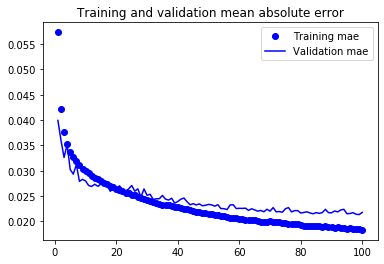

In [ ]:
plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mean absolute error')
plt.legend()

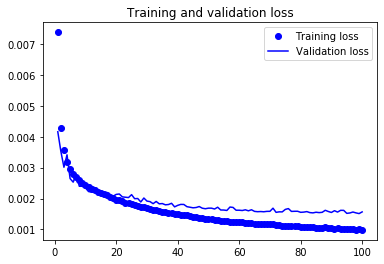

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## **Adding VGG-16 model**

To use this trained model with control interface, it is necessary to add pretrained VGG-16 on top of it so it can process images from interface and outputs driving commands 

In [ ]:
NN = model

In [ ]:
input_shape = (150, 240, 3)

# Input
input_tensor = Input(shape=input_shape)
input_velocidade = Input((1,50))
lamb = Lambda(lambda x: x/255., input_shape=input_shape, name='lambda_norm')(input_tensor)

# Xcpetion
x = conv_base(lamb)
x = Flatten()(x)

x = NN([x,input_velocidade])

#Model
model = Model([input_tensor, input_velocidade], x)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_norm (Lambda)            (None, 150, 240, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 4, 7, 512)    14714688    lambda_norm[0][0]                
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 14336)        0           vgg16[1][0]                      
____________________________________________________________________________________________

In [ ]:
model.save('/content/drive/My Drive/Treinamentos/VGG_MultiModal_Predict_Speed/vgg_avg.h5')

This is the final model that will be used in control interface

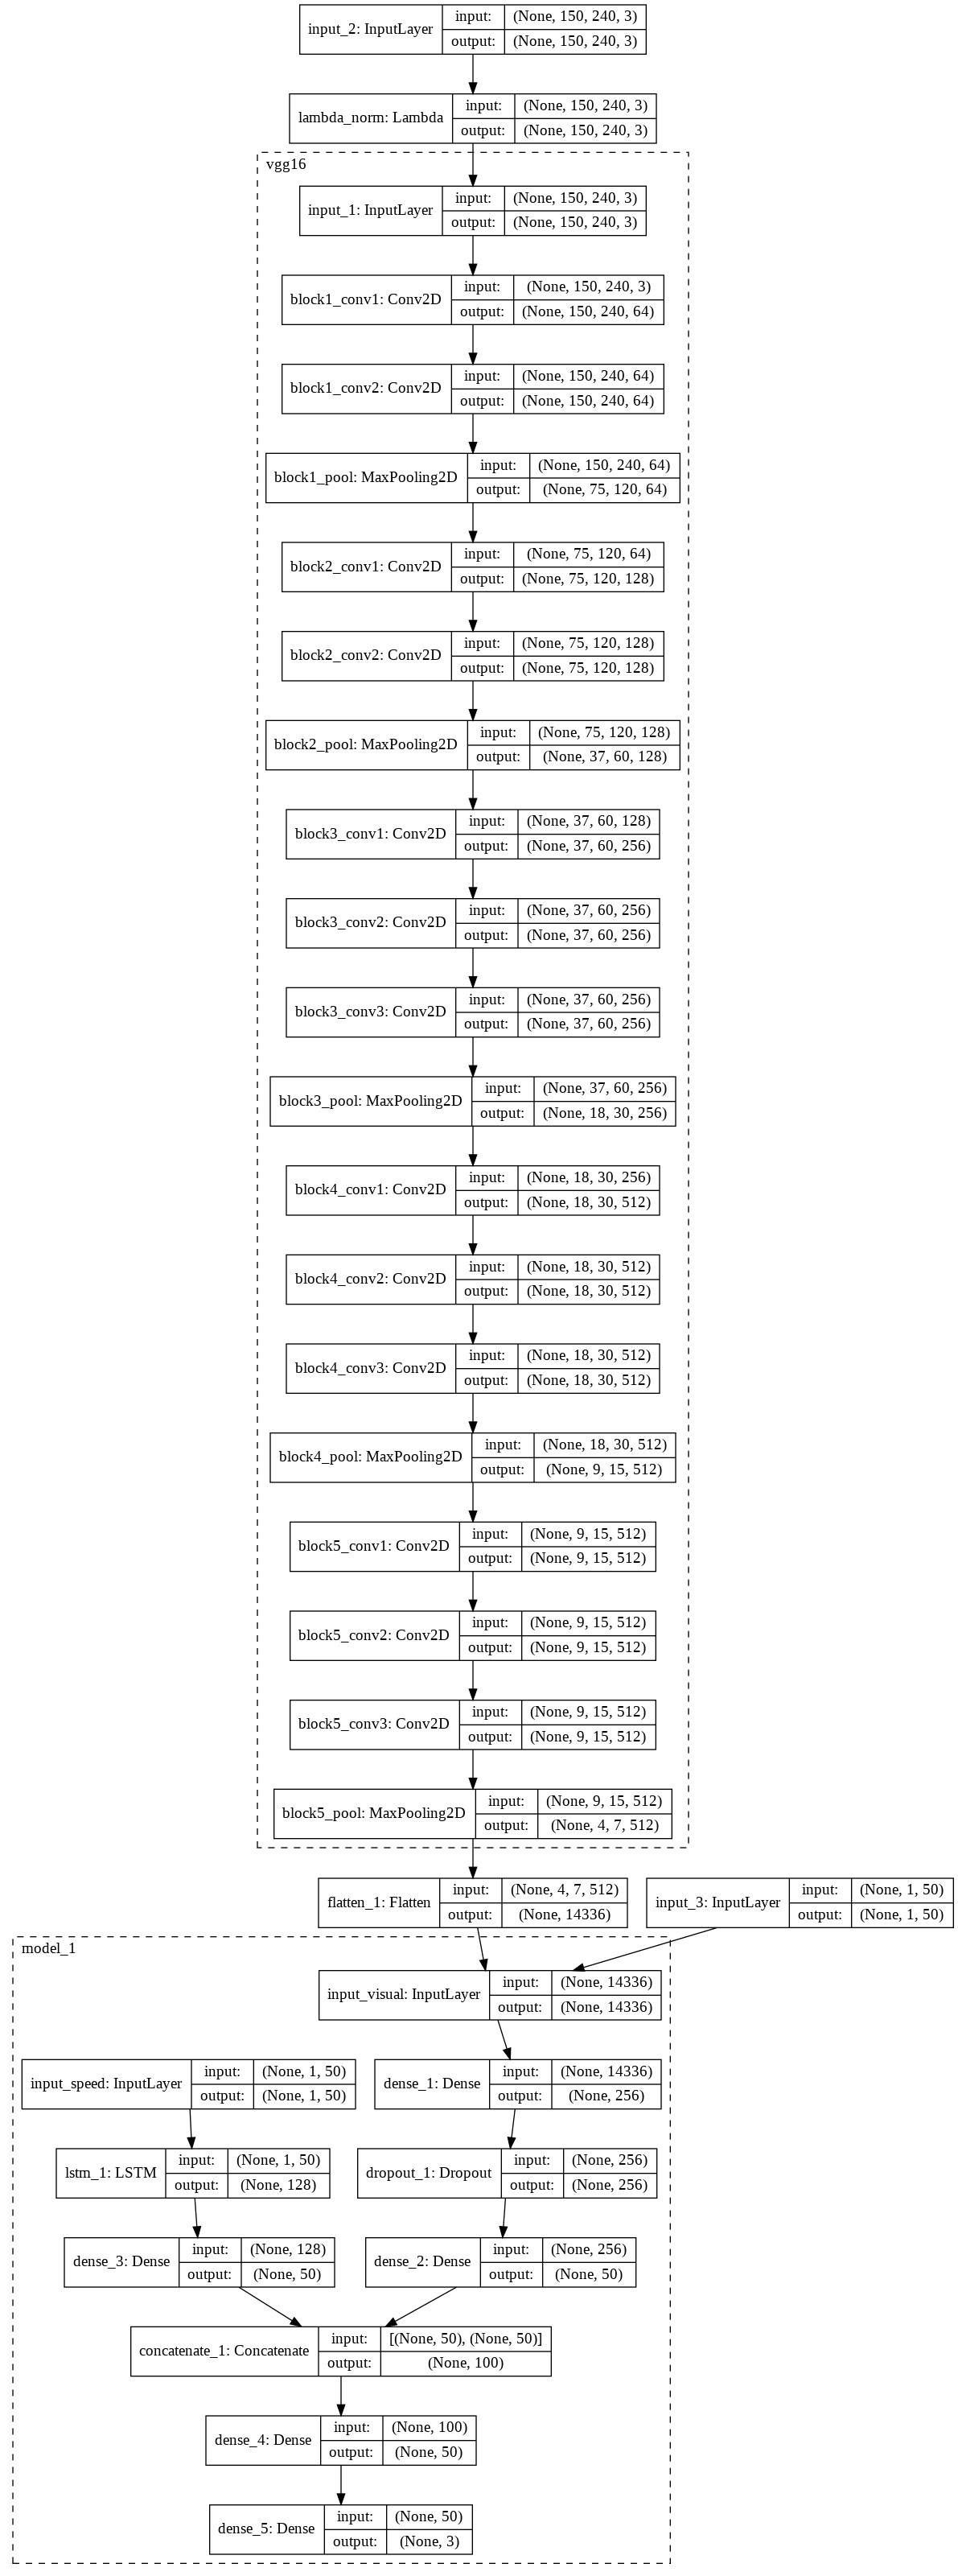

In [ ]:
plot_model(model, to_file = 'model.png', show_shapes = True, expand_nested=True)

## **Testing model**

The following cells loads test data to evaluate the final model

In [ ]:
Y=np.load('/content/drive/My Drive/Novos_Dados/YTreino0.npy')
print("Arquivo 0 carregado")
for i in range(1,35):
    Y=np.concatenate((Y, np.load('/content/drive/My Drive/Novos_Dados/YTreino'+str(i)+'.npy')))
    print("Arquivo %d carregado" %(i))

V=np.zeros((len(Y)-50,50))
for i in range(len(Y)-50):
  V[i,:]=Y[i:i+50,3]
V=V.reshape((len(V),1,50))
Vnorm = np.divide(np.subtract(V, 53.5),28).reshape((len(V),1,50))

Arquivo 0 carregado
Arquivo 1 carregado
Arquivo 2 carregado
Arquivo 3 carregado
Arquivo 4 carregado
Arquivo 5 carregado
Arquivo 6 carregado
Arquivo 7 carregado
Arquivo 8 carregado
Arquivo 9 carregado
Arquivo 10 carregado
Arquivo 11 carregado
Arquivo 12 carregado
Arquivo 13 carregado
Arquivo 14 carregado
Arquivo 15 carregado
Arquivo 16 carregado
Arquivo 17 carregado
Arquivo 18 carregado
Arquivo 19 carregado
Arquivo 20 carregado
Arquivo 21 carregado
Arquivo 22 carregado
Arquivo 23 carregado
Arquivo 24 carregado
Arquivo 25 carregado
Arquivo 26 carregado
Arquivo 27 carregado
Arquivo 28 carregado
Arquivo 29 carregado
Arquivo 30 carregado
Arquivo 31 carregado
Arquivo 32 carregado
Arquivo 33 carregado
Arquivo 34 carregado


In [ ]:
n_base=129565-50
x = np.zeros((n_base,150,240,3),dtype='uint8')
y=np.zeros((n_base,4))
v=np.zeros((n_base,1,50))
vn=np.zeros((n_base,1,50))

soma_train=0
n=0
for i in range(0,35):
  #Carrega
  xi = np.load('/content/drive/My Drive/Novos_Dados/XTreino'+str(i)+'.npy')
  yi = np.load('/content/drive/My Drive/Novos_Dados/YTreino'+str(i)+'.npy')
  print("Arquivo ",i)
  if i==0:
    xi=xi[50:len(xi)]
    yi=yi[50:len(yi)]
  n=len(yi) 

  #Treino
  x[soma_train:soma_train + n]= xi
  y[soma_train:soma_train + n]= yi
  v[soma_train:soma_train + n]= V[soma_train:soma_train + n]
  vn[soma_train:soma_train + n]= Vnorm[soma_train:soma_train + n]

  #Att
  soma_train = soma_train + n

Arquivo  0
Arquivo  1
Arquivo  2
Arquivo  3
Arquivo  4
Arquivo  5
Arquivo  6
Arquivo  7
Arquivo  8
Arquivo  9
Arquivo  10
Arquivo  11
Arquivo  12
Arquivo  13
Arquivo  14
Arquivo  15
Arquivo  16
Arquivo  17
Arquivo  18
Arquivo  19
Arquivo  20
Arquivo  21
Arquivo  22
Arquivo  23
Arquivo  24
Arquivo  25
Arquivo  26
Arquivo  27
Arquivo  28
Arquivo  29
Arquivo  30
Arquivo  31
Arquivo  32
Arquivo  33
Arquivo  34


In [ ]:
np.random.seed(seed=9)
np.random.shuffle(x)
np.random.seed(seed=9)
np.random.shuffle(y)
np.random.seed(seed=9)
np.random.shuffle(vn)

In [ ]:
xtreino = x[0:len(x)-25000]
ytreino = y[0:len(y)-25000]
vntreino = vn[0:len(vn)-25000]
xteste = x[len(x)-25000:len(x)]
yteste = y[len(y)-25000:len(y)]
vnteste = vn[len(vn)-25000:len(vn)]

Finally, the model is tested in test dataset

In [ ]:
model.evaluate([xteste,vnteste],yteste[:,0:3])

25000/25000 [==============================] - 53s 2ms/step


[0.0015260989988781512, 0.021617149641513823]